<a href="https://colab.research.google.com/github/Mohammad-Amirifard/NLP_Tutorial/blob/main/03_Interacting_with_Document_Search_Engines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Learn Natural Language Processing better in a practical Mode**

Created By [Mohammad Amirifard](https://www.linkedin.com/in/mohammad-amirifard/)


<img src="https://th.bing.com/th/id/R.481b9fae699f7619971167cade786c60?rik=PWShnQ5jIirVIA&riu=http%3a%2f%2fwww.marktechpost.com%2fwp-content%2fuploads%2f2022%2f11%2f233-scaled.jpg&ehk=hvDRc3N3UsK9xB5jAui%2b9p1VW98U8f6uUCoUncfmRbY%3d&risl=&pid=ImgRaw&r=0" alt="Image" width="800" height="400" />

# **Structure of notebooks**
`This NLP Tutorial includes several notebooks regarding different parts.`

This is **notebook number 03**, called **Interacting with Document Search Engines**

For other notebooks you can use the following links:


1.   Notebook number 01, [Reading and Manipulating Text data](https://github.com/Mohammad-Amirifard/NLP_Tutorial/blob/main/01_Reading_and_Manipulating_Text_data.ipynb)

2.   Notebook number 02, [Building_a_Text_Classifier](https://github.com/Mohammad-Amirifard/NLP_Tutorial/blob/main/02_Building_a_Text_Classifier.ipynb)

3. Notebook number 03, [Interacting with Document Search Engines]()




# Search engines

This notebook shows how to use [PyTerrier](https://github.com/terrier-org/pyterrier) on the [CORD19 corpus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7251955/) and the [TREC Covid test collection](https://ir.nist.gov/covidSubmit/).
Hereafter we are going to see how to:
- index a collection
- access an index
- search an index
- compare the performances of indexing approaches
- learn ranking
- evaluate ranking

The notebook in mainly based on the tutorials at this [link](https://github.com/terrier-org/cikm2021tutorial/tree/main/notebooks), which are part of the tutorial series "[IR From Bag-of-words to BERT and Beyond through Practical Experiments](https://github.com/terrier-org/cikm2021tutorial/)" created for the [CIKM 2021](https://www.cikm2021.org/).

## Tools installation and configuration

PyTerrier is a Python framework, but uses the underlying [Terrier information retrieval toolkit](http://terrier.org) for many indexing and retrieval operations. While PyTerrier was new in 2020, Terrier is written in Java and has a long history dating back to 2001. PyTerrier makes it easy to perform IR experiments in Python, but using the mature Terrier platform for the expensive indexing and retrieval operations.

PyTerrier is installed as follows. This might take a few minutes, in the meanwhile you can take a look at [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/).

## 3.1 Install PyTerrier  <a name="31-Install-PyTerrier"></a>
We first install the `python-terrier` package, which provides Python bindings for the Terrier Information Retrieval platform.


In [1]:
!pip install -q python-terrier -qq

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.8 MB/s eta 0:00:00


## 3.2 Initialize PyTerrier  <a name="32-Initialize-PyTerrier"></a>

Before using PyTerrier, it must be initialized. Initialization is required because PyTerrier needs to download the Terrier core (JAR file) and start the Java Virtual Machine (JVM).

To avoid initializing PyTerrier multiple times (which can cause errors), we check if it has already been started using `pyterrier.started()`. If not, we call `pyterrier.init()`.

In [2]:
import pyterrier as pt

# Check if PyTerrier has already been started
if not pt.started():
    print("Initializing PyTerrier...")
    print('*' * 100)
    pt.init()
else:
    print("PyTerrier is already initialized.")
    print('*' * 100)



<ipython-input-2-65e306c7911a>:4: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


Initializing PyTerrier...
****************************************************************************************************
terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-2-65e306c7911a>:7: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [3]:
# Check PyTerrier version
print(f"PyTerrier version: {pt.__version__}")

PyTerrier version: 0.13.0



##3.2 Introductory to document indexing and searching  <a name="32-Introductory-to-document-indexing-and-searching"></a>


Much of PyTerrier’s functionality is built around the use of Pandas DataFrames.
In this section, we will explore how to represent a collection of textual documents within a DataFrame and how to index them for later retrieval.

We will begin by importing the necessary library, Pandas.


In [4]:
# Import Pandas
import pandas as pd

# Set display option to prevent text truncation
pd.set_option('display.max_colwidth', 150)

###3.2.1 Creating Documents <a name="321-Create-Documents"></a>


We will now create a small set of example documents and store them in a DataFrame.
Each document will have a unique identifier (`docno`) and associated text content.

In [5]:
# Create a DataFrame containing sample documents
docs_df = pd.DataFrame(
    [
        ["document_1", "This is the first article in my collection of articles. article"],
        ["document_2", "This is another article in my collection."],
        ["document_3", "The topic of this third article is unknown."]
    ],
    columns=["docno", "text"]
)

# Display the created DataFrame
docs_df

,docno,text
0,document_1,This is the first article in my collection of articles. article
1,document_2,This is another article in my collection.
2,document_3,The topic of this third article is unknown.


###3.2.2 Indexing  <a name="322-Indexing"></a>


Before a search engine can determine which documents are most relevant to a given query, it must first index the documents.

In the code below, we use PyTerrier's `DFIndexer` to index the documents stored in our DataFrame.
The index files and data structures are saved in a local directory named `index_3docs`,
which you can view in the Colab file browser on the left panel.

In [6]:
# Create an indexer instance specifying the output directory
indexer = pt.DFIndexer("./index_3docs", overwrite=True)

# Perform the indexing operation and obtain a reference to the created index
index_ref = indexer.index(docs_df["text"], docs_df["docno"])

# Output a summary of the index
print(index_ref.toString())


<ipython-input-6-6f61d0246543>:2: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer = pt.DFIndexer("./index_3docs", overwrite=True)


./index_3docs/data.properties


###3.2.3 Loading indexes

Once documents are indexed, we can load the resulting Terrier index using `IndexFactory.of()`.
This gives access to various low-level structures within the Terrier Information Retrieval system, such as:

- `getCollectionStatistics()` — Retrieve corpus-level statistics.
- `getInvertedIndex()` — Access term-document mappings.
- `getLexicon()` — View the vocabulary and term statistics.

In [7]:
index = pt.IndexFactory.of(index_ref)

In [8]:
# The `getCollectionStatistics()` method provides high-level statistics about the indexed corpus,
# such as the number of documents, number of terms, and average document length. Let’s display these statistics:
print(index.getCollectionStatistics())

Number of documents: 3
Number of terms: 6
Number of postings: 9
Number of fields: 0
Number of tokens: 11
Field names: []
Positions:   false




###3.2.4 Exploring the Lexicon (Vocabulary)
At a glance, we can confirm that 3 documents have been indexed.
However, you may notice that only 6 terms are listed.
This is because stopwords have been removed, and stemming (via Porter Stemmer) has been applied.


The `getLexicon()` method allows us to iterate over the indexed terms.
Each term entry includes useful statistics:

- `termX`: the ith_unique term found in all documents.
- `Nt`: Number of documents containing the term (important for calculating Inverse Document Frequency — IDF).
- `TF`: Total frequency of the term across the entire corpus.
- `maxTF`: The maximum Term Freqeuncy of all documents

Let's print out the full lexicon:

In [9]:
for kv in index.getLexicon():
    print(kv.getKey(),": ", kv.getValue().toString())

articl :  term1 Nt=3 TF=5 maxTF=3 @{0 0 0}
collect :  term0 Nt=2 TF=2 maxTF=1 @{0 1 0}
first :  term2 Nt=1 TF=1 maxTF=1 @{0 1 4}
third :  term4 Nt=1 TF=1 maxTF=1 @{0 1 6}
topic :  term3 Nt=1 TF=1 maxTF=1 @{0 2 2}
unknown :  term5 Nt=1 TF=1 maxTF=1 @{0 2 6}


###3.2.5 Looking Up Specific Terms

We can directly access specific terms in the lexicon using square bracket notation.
Let’s retrieve information about the stemmed term `"articl"`:

In [10]:
index.getLexicon()["articl"].toString()

'term1 Nt=3 TF=5 maxTF=3 @{0 0 0}'

And we can see how many times this term is used in each document that it occurs in (by iterating over the posting lists):

In [11]:
pointer = index.getLexicon()["articl"]
print("The term 'article' occurs in the following documents:")
print("ID: Document Index, TF: Term Frequncy, doclen: number of the terms found in document ")
for posting in index.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')

The term 'article' occurs in the following documents:
ID: Document Index, TF: Term Frequncy, doclen: number of the terms found in document 
ID(0) TF(3) doclen = 5
ID(1) TF(1) doclen = 2
ID(2) TF(1) doclen = 4


We can see that `"article"` occurs in each of the three documents.

###3.2.6 Searching a Query by TF-IDF

Now that we have indexed our documents, we can perform searches over the collection.

In this example, we will use PyTerrier’s `BatchRetrieve` class to execute a simple query.
We will retrieve results using the **TF-IDF** weighting model.


**TF-IDF Formula**

The **TF-IDF** score of a term *t* in a document *d* is calculated as:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

where:
- $\text{TF}(t, d)$ = Number of times term *t* appears in document *d*.
- $\text{IDF}(t)$ = Inverse Document Frequency of term *t*, calculated as:

$$
\text{IDF}(t) = \log \left( \frac{N}{\text{DF}(t)} \right)
$$

- $N$ = Total number of documents.
- ${DF}(t)$ = Number of documents containing term *t*.

---

**BM25 Formula**

The **BM25** score of a document *d* for a query containing term *t* is given by:

$$
\text{BM25}(t, d) = \text{IDF}(t) \times \frac{f(t, d) \times (k_1 + 1)}{f(t, d) + k_1 \times (1 - b + b \times \frac{|d|}{\text{avgdl}})}
$$

where:

- $ f(t, d) $ = Term frequency of term *t* in document *d*.
- $ |d| $ = Length of document *d* (e.g., number of tokens).
- $\text{avgdl} $ = Average document length across the corpus.
- $ k_1 $ = Term frequency scaling factor (commonly set around 1.2 or 1.5).
- $ b $ = Document length normalization factor (commonly set to 0.75).

The IDF term in BM25 is calculated slightly differently:

$$
\text{IDF}(t) = \log \left( \frac{N - \text{DF}(t) + 0.5}{\text{DF}(t) + 0.5} + 1 \right)
$$

- $N $ = Total number of documents.
- $ \text{DF}(t) $
 = Number of documents containing term *t*.

---


<ipython-input-12-c8ace36b6048>:5: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index, wmodel="TF_IDF")


,docid,docno,rank,score
0,0,document_1,0,0.795181
1,1,document_2,1,0.670051
2,2,document_3,2,0.525896


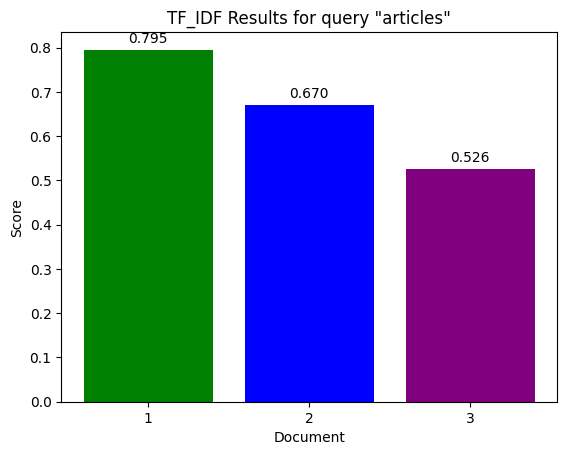

In [12]:
# Define the search query
query = "articles"

# Create a retrieval object using the TF-IDF weighting model
retriever = pt.BatchRetrieve(index, wmodel="TF_IDF")

# Execute the search
tf_idf_results = retriever.search(query)

# Display the top retrieved documents
display(tf_idf_results[["docid", "docno", "rank", "score"]])

# Plot the results
from matplotlib import pyplot as plt
def plot_results(results,query=query,mpdel_name="TF_IDF"):

  scores = results['score']
  plt.bar(x=[str(i+1) for i in range(3)], height=scores,color=['green','blue','purple'])

  # Show the value of each on top
  for i, v in enumerate(scores):
      plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
  plt.title(f'{mpdel_name} Results for query "{query}"')
  plt.xlabel('Document')
  plt.ylabel('Score')
  plt.show()

plot_results(tf_idf_results)

Here we used the TF-IDF weighting formula to rank the results.

The `search()` method returns a dataframe with columns:
 - `qid`: the query identifier
 - `docid`: integer identifier for document
 - `docno`: string identifier for document
 - `rank`: rank position
 - `score`: tf-idf score


###3.2.7 Searching a Query by BM25


<ipython-input-13-6126c78537e9>:7: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_retriever  = pt.BatchRetrieve(index, wmodel="BM25")


,docid,docno,rank,score
0,2,document_3,0,-2.706693
1,1,document_2,1,-3.448629
2,0,document_1,2,-4.092650


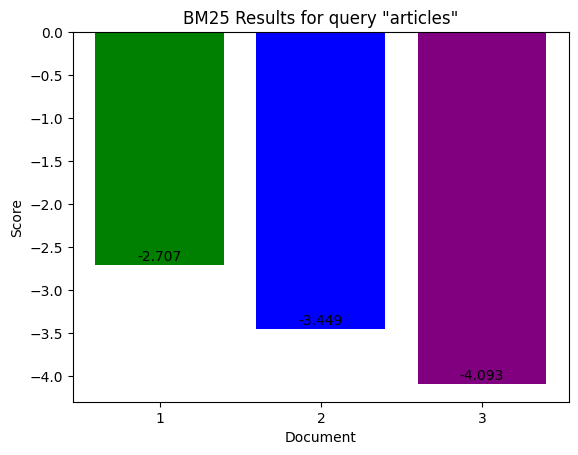

In [13]:
# Switching to BM25 (very popular and usually better than plain TF-IDF)

# Define the search query
query = "articles"

# Create a retrieval object using the TF-IDF weighting model
bm25_retriever  = pt.BatchRetrieve(index, wmodel="BM25")

# Execute the search
bm25_results  = bm25_retriever .search(query)

# Display the top retrieved documents
display(bm25_results [["docid", "docno", "rank", "score"]])
plot_results(bm25_results,mpdel_name="BM25")

###3.2.8 Multiple Searching

We can also run multiple queries at once:

In [14]:
# Define multiple queries correctly
queries = pd.DataFrame({
    "qid": ["q1", "q2", "q3"],
    "query": ["articles", "first article", "unknown"]
})

# Use the recommended Retriever class (not the deprecated BatchRetrieve)
retriever = pt.terrier.Retriever(index, wmodel="TF_IDF")

# Run the search
tf_idf_results = retriever.transform(queries)

# Display results
display(tf_idf_results[["qid", "docid", "rank", "score"]])

,qid,docid,rank,score
0,q1,0,0,0.795181
1,q1,1,1,0.670051
2,q1,2,2,0.525896
3,q2,0,0,1.744821
4,q2,1,1,0.670051
5,q2,2,2,0.525896
6,q3,2,0,1.051793


##3.3 Load a real dataset

We'll now load a real dataset of COVID-19 related scientific articles (called CORD19) that is available as an example in PyTerrier

In [15]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
# just extract the document number and abstraxt text from the corpus using th following code:
def corpus_iterator():
    for doc in cord19.get_corpus_iter():
        yield {
            'docno': doc['docno'],
            'text': doc['abstract']  # <= map 'abstract' into 'text'
        }

pt_index_path = './terrier_cord19'

We just downloaded the data. Now we index and save the dataset.

The CORD19 corpus contains articles about the COVID-19, we are going to retrieve only the abstract of these articles to compose our documents. The indexing will take a while to run since there are almost 200,000 articles.

###3.3.1 Indexing

In [16]:
# Create an indexer
indexer = pt.index.IterDictIndexer(
    pt_index_path,
    overwrite=True,
    meta={'docno': 20} # Just store the docno with the maximum length 20
)

# Build the index
index_ref = indexer.index(corpus_iterator())


[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 [00:00<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M [00:00<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 57.3k/269M [00:00<10:29, 428kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.1%| 279k/269M [00:00<04:26, 1.01MB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.4%| 975k/269M [00:00<01:55, 2.33MB/s]
https://ai2-semanticscholar-cord-1

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

21:06:33.165 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
21:07:58.525 [ForkJoinPool-1-worker-3] ERROR org.terrier.structures.indexing.Indexer -- Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.indexDocuments(BasicIndexer.java:270)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:388)
	at org.terrier.structures.indexing.Indexer.index(In

###3.3.2 Loading indexes

Now load the index and print the statistics:

In [17]:
index = pt.IndexFactory.of(index_ref)
# The `getCollectionStatistics()` method provides high-level statistics about the indexed corpus,
# such as the number of documents, number of terms, and average document length. Let’s display these statistics:
print(index.getCollectionStatistics().toString())

Number of documents: 192509
Number of terms: 151235
Number of postings: 11554033
Number of fields: 0
Number of tokens: 17728468
Field names: []
Positions:   false



###3.3.3 Searching a Query by TF-IDF and BM25

In [18]:
query = "chemical reactions"

tf_idf_results = pt.BatchRetrieve(index, wmodel="TF_IDF")
tf_idf_results.search(query)


<ipython-input-18-951d9231a2f0>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tf_idf_results = pt.BatchRetrieve(index, wmodel="TF_IDF")


,qid,docid,docno,rank,score,query
0,1,18717,iavwkdpr,0,11.035982,chemical reactions
1,1,171636,v3blnh02,1,10.329726,chemical reactions
2,1,147193,ei4rb8fr,2,10.317138,chemical reactions
3,1,121217,msdycum2,3,9.653734,chemical reactions
4,1,170863,sj8i9ss2,4,9.500211,chemical reactions
...,...,...,...,...,...,...
995,1,2428,38aabxh1,995,3.790183,chemical reactions
996,1,14752,u709r8ss,996,3.790183,chemical reactions
997,1,20074,wxi1xsbo,997,3.790183,chemical reactions
998,1,117156,ts3obwts,998,3.790183,chemical reactions


In [20]:
query = "chemical reactions"

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query)

<ipython-input-20-783309414b14>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index, wmodel="BM25")


,qid,docid,docno,rank,score,query
0,1,18717,iavwkdpr,0,20.011607,chemical reactions
1,1,171636,v3blnh02,1,18.723538,chemical reactions
2,1,147193,ei4rb8fr,2,18.700723,chemical reactions
3,1,121217,msdycum2,3,17.498245,chemical reactions
4,1,170863,sj8i9ss2,4,17.228355,chemical reactions
...,...,...,...,...,...,...
995,1,88455,cuvqym6y,995,6.855393,chemical reactions
996,1,137287,8kfjw8ai,996,6.855393,chemical reactions
997,1,140078,kebvzeg4,997,6.855393,chemical reactions
998,1,148411,hhcfrjrn,998,6.855393,chemical reactions


## Evaluating retrieval

So far, we have been creating search engine models, but we haven't decided if any of them are actually any good. In order to determine how good a ranking is, we need annotations telling us which documents are actually relevant for a particular query.

The CORD19 dataset contains set of queries and relevance assessments (aka qrels)for this purpose.

For historical reasons, the queries are called "topics". Let's have a look at the first 10 queries:

In [ ]:
queries = cord19.get_topics(variant='title')
queries.head(10)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [30.6MB/s]


,qid,query
0,1,coronavirus origin
1,2,coronavirus response to weather changes
2,3,coronavirus immunity
3,4,how do people die from the coronavirus
4,5,animal models of covid 19
5,6,coronavirus test rapid testing
6,7,serological tests for coronavirus
7,8,coronavirus under reporting
8,9,coronavirus in canada
9,10,coronavirus social distancing impact


And the first 10 relevance judgements (called qrels):

In [ ]:
qrels = cord19.get_qrels()
qrels.head(10)

We can give a look at the distribution of the relevance scores in the data set. To do so we train the count of occurrences of each label, sort the values by label and plot these values in a bat plot (note the log-scale on the y-axis):

In [ ]:
qrels['label'].value_counts().plot(kind='bar', log=True)

Note that there are some relevance judgements taking the value of -1. In the original documentation of the data set (https://ir-datasets.com/cord19.html) only the values 0, 1, and 2 are accepted, so the -1 must be errors in the annotation, since they are only 2 we can drop the corresponding qrels.

To drop the undesired we simply have to retain all the qrels with a label different from -1

In [ ]:
qrels = qrels[qrels['label'] != -1]

The qrels contain information on the relevance labels for the query-document pairs. To do our evaluation we need to load also the queries we are going to use to test our retrieval system. For historical reasons, queries are called "topics" in this context.

Let's collect the topics in the CORD-19 corpus:

In [ ]:
topics = cord19.get_topics(variant='title')
topics

Now let us use these queries and relevance judgements to compare different retrieval functions to see how well they perform at ranking documents in the collection. We compare BM25 and TF-IDF in terms of two common ranking evaluation measures (MAP and NDCG), where higher values indicate a better ranking:  

In [ ]:
pt.Experiment(
    [tfidf, bm25],
    topics,
    qrels,
    eval_metrics=["map", "ndcg"]
)

How were those scores calculated? We can have a look at the score and corresponding relevance labels for individual query document pairs as follows:

In [ ]:
# Rank the documents for each query using the TF-IDF scoring function:
results = tfidf(cord19.get_topics(variant='title'))
# Add the relevance labels (qrels) to the table:
results = results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)
# Display the output
results

## Pipelines

For this part of the notebook, we'll be using a different (pre-built) Terrier index with term position information, which was built uisng the following code. (We wont run it now since it would take a while to run.)
```python
pt_index_path = './terrier_cord19_blocks'
indexer = pt.index.IterDictIndexer(pt_index_path blocks=True)
index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))
```

However, its just as quick to use the pre-built index from the Terrier Data Repository. We use the ['terrier_stemmed_positions'](http://data.terrier.org/trec-covid.dataset.html#terrier_stemmed_positions) index variant.

In [ ]:
index = pt.IndexFactory.of(
    pt.get_dataset('trec-covid').get_index('terrier_stemmed_positions')
)

#### Operators

`BatchRetrieve` objects can be combined using some special operators. These combinations are called pipelines.

Hereafter we are going to see three operators:
- Composition
- Rank cut-off
- Union

Before moving to the actual operators se define three retrievers using the index we have just created. We are going to define retrievers using
- TF
- TF-IDF
- BM25

In [ ]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

##### Composition

The first operator we are going to see is the composition. This operator allow to re-rank the output of one retriever using a second retriever.

To use it, we simply need to compose two retrievers using the  `>>` operator.

Given the first query in the topics we loaded before

In [ ]:
query = 'chemical'

Let's see first what TF alone would retrieve

In [ ]:
tf.search(query)

Now let's compose the TF with the BM25, in this way we will re-rank the TF-IDF results using BM25.

First we create a composition an then run the search using the composition pipeline.

In [ ]:
composition = tf >> bm25

composition.search(query)

As you can see some documents have been further re-ordered by the BM25

##### Rank cut-off

The second operator we are going to see is the rank cut-off. This operator allow to retain only the top *n* results.

To use it, we simply need to compose a new retriever applying the `% n` operator to an existing retriever (with *n* being the number of results we want to retain. This is useful to do an early pruning of the the retreived results.

Let's retain the top 10 results using the TF-IDF score.

First we define the rank cut-off pipeline using the TF retriever, then we use it to answer the query.

In [ ]:
tf_idf_cut = tf_idf % 10

tf_idf_cut.search(query)

Of course these pipeline operators can be combined. For example we can re-rank with BM25 only the first 20 results from TF.

Again we define first our pipeline with the two operations and then we search the query.

In [ ]:
combination_cut = (tf % 20) >> bm25

combination_cut.search(query)

##### Results union

Finally we can also combine the results from different retreivers, merging them together. In this case we are going to define the pipeline using two retrievers interleaved by the `|` operator.

For example we can combine the top 10 results from TF with the top 10 results from TF-IDF. As usual we define first our pipeline and then we run our query.

In [ ]:
union = (tf % 10) | (tf_idf % 10)

union.search(query)

There are some overlappings between the results of TF and TF-IDf, as a results the total number of retreived documents is lower than 20.
Also nothe that we do not have scores here since TF and TF-IDF are not comparable.

What we can do is add som re-ranking to our pipeline. We can re-score the output given by the union of TF (with cut-off at 10) and TF-IDF (with cut-off at 10) using BM25

In [ ]:
pipeline = ((tf % 10) | (tf_idf % 10)) >> bm25

pipeline.search(query)

#### Evaluating retireval pipelines

How do these complex retrieval pipelines perform?

We can compare the MAP and NDCG scores on the topics avaialble on the CORD-19 data set using the qrels we loaded before.

Let's compare
- BM25 (used as baseline)
- TF-IDF re-scored with BM25
- the union of TF-IDF and TF top 500 results re-scored with BM25

In [ ]:
pt.Experiment(
  [bm25, tf_idf >> bm25, ((tf % 500) | (tf_idf % 500)) >> bm25],
  topics,
  qrels,
  eval_metrics=["map", "ndcg"],
  names=["BM25", "TF-IDF >> BM25", "((TF % 10) | (TF-IDF % 10)) >> BM25"]
)

## Learning to Rank

In this last part of the notebook, you will experience constructing, learning, evaluating and analysing learning to rank pipelines.


Firstly, lets split out topics into train, validation and test sets. TREC Covid only has 50 topics, which isnt a lot for training. We'll split this 30 for training 5 for validation and 15 for test. We will also examine statistical significance, even if this is artificial for 15 topics.

We're only going to-rank the top 10 documents for each query - hopefully learning to rank can help to re-rank the top 10 documents to be more effective.

We define some constants to controthe cutoff and make the experiments reproducible

In [ ]:
RANK_CUTOFF = 10
SEED = 42

Then we use the splitting utility from Scikit-Learn

In [ ]:
from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)

### Feature Set

Lets define our feature set.  We're going to have a total of 5 features:

1.   the BM25 abstract score;
2.   the BM25 score on the title;
3.   whether the abstract contain 'coronavirus covid', scored by BM25;
4.   whether the paper was released/published in 2020 (Recent papers were more useful for this task);
5.   whether the paper is a formal publication? (we can get this information checking whether the paper has a special identifier called DOI)

Several of these feature require additional metadata `["title", "date", "doi"]`. Fortunately, the TREC Covid dataset allows us to obtain more metadata after indexing. We use `pt.text.get_text(cord19, ["title", "date", "doi"])` to retrieve these extra metadata columns.

Note the complete pipeline definition is a bit complex, just keep in mind we are interested in extracting the features we just listed

In [ ]:
ltr_feats = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') )
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0)))
)

For reference, we create a list with the names of the features

In [ ]:
fnames=["BM25 abstract", "BM25 title", "coronavirus covid", "2020", "DOI"]

Lets see the output for a given query.

In [ ]:
ltr_feats.search("coronovirus origin")

We can see that we now have extra document metadata columns `["title", "date", "doi"]`, as well as the `"features"` column. This last column contains the array of features we are going to use in the learning step

We can also look at the raw features values (in this case for the first ranked document)

In [ ]:
print('Features:', ltr_feats.search("coronovirus origin").iloc[0]["features"])

### Learning

In this part of the notebook, we apply three different learning to rank techniques:

 - coordinate ascent from FastRank, a listwise linear technique
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - LambdaMART from LightGBM, a listwise regression tree technique

In each case, we take our feature pipeline, `ltr_feats1`, and we compose it (`>>`) with the learned model. We use `pt.ltr.apply_learned_model()` which knows how to deal with different learners.

The full pipeline is then fitted (learned) using `.fit()`, specifying the training topics and qrels. Importantly, the preceeding stages of the pipeline (retrieval and feature calculation) are applied to the training topics in order to obtained the results, which are then passed to the learning to rank technique. LightGBM has early stopping enabled, which uses a validation topics set – similarly the validation topics are transformed into validation results.


#### Linear regression model

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr_pipe = ltr_feats >> pt.ltr.apply_learned_model(lr)

lr_pipe.fit(train_topics, qrels)

#### Non-linear regression model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=-1)

rf_pipe = ltr_feats >> pt.ltr.apply_learned_model(rf)

rf_pipe.fit(train_topics, qrels)

#### LambdaMART

LambdaMART is a listwise appraoch to learning to rank documents. It makes use of Gradient Boosted Regression trees to optimize an approximation to the NDCG evaluation function.

To learn a LambdaMART model we first need to install [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

In [ ]:
!pip install -q --upgrade lightgbm==3.1.1

Now we can train the model:

In [ ]:
import lightgbm as lgb

# This configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

### Evaluation

Lets now compare our ranking pipelines on our 15 topics with the BM25 baseline.

We'll report MAP, NDCG measures.

In [ ]:
pt.Experiment(
    [bm25 % RANK_CUTOFF, lr_pipe, rf_pipe, lmart_x_pipe],
    test_topics,
    qrels,
    names=["BM25",  "BM25 + LinearRegression", "BM25 + RandomForest", "BM25 + LambdaMART"],
    eval_metrics=["map", "ndcg"]
)

The non-linear regression model produced the best results

### Analysis

We can also analyze our learned models to understand the role of the different features we are using.

One way to do this analysis is to plot feature weights or importance from the different learned models. For the Linear Regression model, we plot the feature weights, while for the Random Forest and LambdaMART we report the feature importance.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Create figure
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 8))

# Plot Linear Regression model weights
ax0.bar(np.arange(len(fnames)), lr.coef_)
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Linear Regression")
ax0.set_ylabel("Feature Weights")
# Plot Random Forest feature importance
ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forest")
ax1.set_ylabel("Feature Importance")
# Plot LmbdaMART feature importance
ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART")
ax2.set_ylabel("Feature Importance")

# Display figure
plt.tight_layout()
plt.show()
